<a href="https://colab.research.google.com/github/sacktock/EDVAM-models/blob/main/LSTM_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM model for time series prediction and sequence generation in the EDVAM dataset**

EDVAM: the first 3D eye tracking dataset for a virtual world. https://github.com/YunzhanZHOU/EDVAM

**The Problem:**

We redefine the original problem from a classification task to a more refined spatial prediction problem. We condiser the following 9 features:


*   3D point of gaze (PoG) [X, Y, Z] - 3 features.
*   Camera position [X, Y, Z] - 3 features.
*   Camera orientation vector [X, Y, Z] - 3 features.

We consider a frame as a 9-tuple of real values for each of these features. Using the EDVAM dataset which consists of time sequences of these frames collected from 63 participants, we train an LSTM model to predict the next frame from the current frame.

The goal of this is to acheive a more refined prediction for subsequent visual attention by generating time sequences into the future.








**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Install Dependencies**

In [ ]:
!pip install livelossplot

**Imports**

In [ ]:
import pandas as pd
import numpy as np
import csv
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Construct the Dataset**

Using the EDVAM raw subset we construct training examples. Using a sliding window of 3 seconds (90 frames) we generate sequences of frames as training examples, the targets for our training examples are the same frames but they have been time-shifted by 1.

In [ ]:
dataset = []

# read in data from the raw EDVAM dataset
for num in range(1, 64):
  dataset.append(np.array(pd.DataFrame(pd.read_csv('drive/My Drive/EDVAM_raw_subset/'+str(num)+'.csv', header=0)).iloc[:,2:11]))

train_set = []
train_targets = []

test_set = []
test_targets = []

test_ids = [54, 40, 38, 52, 62, 58, 46, 12, 24]

seq_len = 90

for num in range(0, 63):
  if num not in test_ids:
    train_set.extend([np.array(dataset[num][i:i+seq_len, :], dtype=np.float32) for i in range(len(dataset[num]) - seq_len)])
    train_targets.extend([np.array(dataset[num][i+1:i+seq_len+1, :], dtype=np.float32) for i in range(len(dataset[num]) - seq_len)])

  else:
    test_set.extend([np.array(dataset[num][i:i+seq_len, :], dtype=np.float32) for i in range(len(dataset[num]) - seq_len)])
    test_targets.extend([np.array(dataset[num][i+1:i+seq_len+1, :], dtype=np.float32) for i in range(len(dataset[num]) - seq_len)])

train_set = np.array(train_set)
train_targets = np.array(train_targets)

test_set = np.array(test_set)
test_targets = np.array(test_targets)

**Visualizing Time Sequences**

Let's visualize some time sequences from the test data by plotting them on 3D axes. 

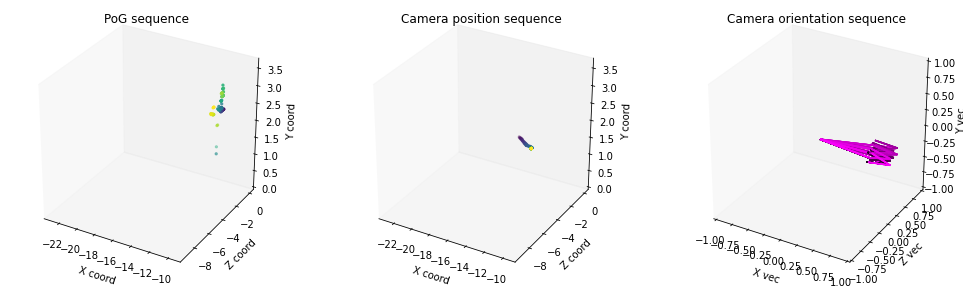

In [ ]:
def plot_seq(arr): # requires non-normalized data
  seq_len = arr.shape[0]

  # PoG (x, y, z)
  x_p = arr[:, 0]
  y_p = arr[:, 1]
  z_p = arr[:, 2]

  # Camera pos (x, y, z)
  x_c = arr[:, 3]
  y_c = arr[:, 4]
  z_c = arr[:, 5]

  # Camera vec (x, y, z)
  x_o = arr[:, 6]
  y_o = arr[:, 7]
  z_o = arr[:, 8]
  
  fig = plt.figure(figsize=(17, 5))

  ax = fig.add_subplot(1,3,1, projection='3d')

  ax.set_title("PoG sequence")
  ax.set_xlabel("X coord")
  ax.set_ylabel("Z coord")
  ax.set_zlabel("Y coord")

  ax.set_xlim(-23.4, -9)
  ax.set_zlim(0,3.7)
  ax.set_ylim(-9.7,0.4)

  ax.grid(False)
  ax.scatter(x_p,z_p,y_p, c=np.arange(seq_len, seq_len*2), marker='.')

  ax = fig.add_subplot(1,3,2, projection='3d')

  ax.set_title("Camera position sequence")
  ax.set_xlabel("X coord")
  ax.set_ylabel("Z coord")
  ax.set_zlabel("Y coord")

  ax.set_xlim(-23.4, -9)
  ax.set_zlim(0,3.7)
  ax.set_ylim(-9.7,0.4)

  ax.grid(False)
  ax.scatter(x_c,z_c,y_c, c=np.arange(seq_len, seq_len*2), marker='.')

  ax = fig.add_subplot(1,3,3, projection='3d')

  ax.set_title("Camera orientation sequence")
  ax.set_xlabel("X vec")
  ax.set_ylabel("Z vec")
  ax.set_zlabel("Y vec")

  ax.set_xlim(-1, 1)
  ax.set_zlim(-1,1)
  ax.set_ylim(-1,1)

  ax.grid(False)
  # visualize camera orientations as unit vectors
  ax.quiver(np.zeros_like(90,), np.zeros_like(90,), np.zeros_like(90,), x_o, y_o, z_o, 
            colors=[(col, 0, col) for col in np.arange(0,1.0,step=(1/seq_len))])

  plt.show()

idx = np.random.choice(test_ids)
start = np.random.randint(0, dataset[idx].shape[0] - seq_len)

plot_seq(np.array([dataset[idx][start+i, :] for i in range(seq_len)]))

**Normalize the Data**

We normalize the data so that no feature takes priority over the other when training the network.

In [ ]:
means = np.array([[[-14.36113819,   1.6289878,   -4.3960396,  -16.36456295,   1.71260748,
                     -4.05706022,   0.49849881,  -0.03998035,  -0.03879195]]], dtype=np.float32)

stds = np.array([[[4.03698547, 0.8635303,  2.79440592, 2.69018196, 0.06613871, 1.5993084,
                   0.65815014, 0.17796627, 0.54445267]]], dtype=np.float32)

 # normalize both datasets using pre-computed means and stds
train_set = (train_set - means) / stds
train_targets = (train_targets - means) / stds

test_set = (test_set - means) / stds
test_targets = (test_targets - means) /stds

**Hyper-params**

In [ ]:
batch_size = 128
learning_rate = 0.001
n_epoch = 30

do_teacher_forcing = True
epsilon = 0.5

lr_halflife = 30. # learning rate decay in epochs
lr_decay_rate = .1**(1./lr_halflife) # decay by a factor of 10 after 30 epochs

**Setup the Dataloaders**

In [ ]:
# wrap data in tensors and init data loaders
train_data = TensorDataset(torch.from_numpy(train_set), torch.from_numpy(train_targets))
test_data = TensorDataset(torch.from_numpy(test_set), torch.from_numpy(test_targets))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

dataloaders = {"train": train_loader, "test": test_loader}

**Define the Model**

In [ ]:
class LSTMModel(nn.Module):

  def __init__(self, input_size, output_size, hidden_dim=75, dropout=0):
    super().__init__()    
    self.output_size = output_size
    self.hidden_dim = hidden_dim

    self.drop = nn.Dropout(dropout)
    self.lstm = nn.LSTMCell(input_size, hidden_dim)
    self.linear = nn.Linear(hidden_dim, output_size)

    self.init_weights()
    self.init_hidden()

  def init_weights(self):
    # init the weights of the linear layer
    initrange = 0.1
    self.linear.bias.data.zero_()
    self.linear.weight.data.uniform_(-initrange, initrange)

    # set the forget gate bias to 1
    n = self.lstm.bias_hh.size(0)
    start, end = n//4, n//2
    self.lstm.bias_hh.data[start:end].fill_(1.)

    n = self.lstm.bias_ih.size(0)
    start, end = n//4, n//2
    self.lstm.bias_ih.data[start:end].fill_(1.)

  def init_hidden(self):
    # init the trainable initial hidden state
    h0 = torch.zeros(1, self.hidden_dim).to(device)
    c0 = torch.zeros(1, self.hidden_dim).to(device)
    nn.init.xavier_normal_(h0, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_normal_(c0, gain=nn.init.calculate_gain('relu'))
    self.h0 = nn.Parameter(h0, requires_grad=True) 
    self.c0 = nn.Parameter(c0, requires_grad=True)

  def forward(self, input, future=0, y=None):
    outputs = []
    input = input.float()
    batch_size = input.shape[0]

    # initial hidden state 
    h_t, c_t = (self.h0.repeat(batch_size, 1), self.c0.repeat(batch_size, 1))

    for i, input in enumerate(input.chunk(input.size(1), dim=1)):
      h_t, c_t = self.lstm(input.squeeze(1), (h_t, c_t))
      output = self.linear(self.drop(h_t))
      outputs += [output]

    for i in range(future):
      # with probability epsilon use the current output as input
      if y is not None and np.random.random() > epsilon:
        output = y[:, [i]].squeeze()  # teacher forcing
      h_t, c_t = self.lstm(output, (h_t, c_t))
      output = self.linear(h_t)
      outputs += [output]

    outputs = torch.stack(outputs, 1).squeeze(2)
    return outputs

input_size = 9
output_size = 9

model = LSTMModel(input_size, output_size).to(device)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True) # SGD gives us poor convergence
liveplot = PlotLosses()

**Training Code**

We will use a simple and (probably) naive variant of Teacher Forcing to train the LSTM model. With Teacher Forcing we pass the output of the model as input with some probability (epsilon) during training otherwise we provide the correct input or target.   

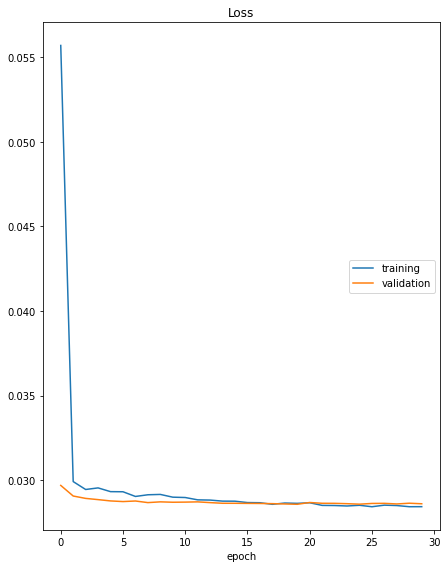

Loss
	training         	 (min:    0.028, max:    0.056, cur:    0.028)
	validation       	 (min:    0.029, max:    0.030, cur:    0.029)
Epoch 30/30, epsilon 0.50, train_loss: 0.028432, val_loss: 0.028603, best_val_loss: 0.028573, best_epoch: 19


In [ ]:
# helper function to set learning rate
def set_lr(lr):
  for param_group in optim.param_groups:
    param_group['lr'] = lr

epoch = 0
best_val_loss = np.inf
best_epoch = 0

while (epoch < n_epoch):
  epoch_loss = {}
  for phase in ["train", "test"]:
    if phase == "train":
      model.train()
    else:
      model.eval()

    loss_arr = np.zeros(0)

    for inputs, targets in dataloaders[phase]:
      inputs, targets = inputs.to(device), targets.to(device)

      if phase == "train" and do_teacher_forcing == True:
        future = np.random.randint(1, int(seq_len) / 2)
        limit = inputs.shape[1] - future
        outputs = model(inputs[:, :limit], future=future, y=targets[:, limit:])
      else:
        outputs = model(inputs)
      
      # minimize spatial losses for all features and all inputs
      loss = nn.MSELoss()(outputs, targets) 

      # parameter update step
      if phase == "train":
        optim.zero_grad()
        loss.backward()
        optim.step()

      loss_arr = np.append(loss_arr, loss.item())

    epoch_loss[phase] = loss_arr.mean()

    if phase == "test" and epoch_loss[phase] < best_val_loss:
      best_epoch = epoch
      best_val_loss = epoch_loss[phase]
      torch.save({'model':model.state_dict()}, 'drive/My Drive/training/LSTM_series.chkpt')

  epoch += 1
  
  learning_rate *= lr_decay_rate
  set_lr(learning_rate)

  liveplot.update({"loss" : epoch_loss["train"], "val_loss" : epoch_loss["test"]})
  liveplot.send()
  print('Epoch {}/{}, epsilon {:.2f}, train_loss: {:.6f}, val_loss: {:.6f}, best_val_loss: {:.6f}, best_epoch: {}'.format(epoch, n_epoch, epsilon, epoch_loss["train"],epoch_loss["test"], best_val_loss, best_epoch))
  

# Evaluate the model

Let's load our best model and have a look at some regression metrics and accuracy scores for each of the features.

In [ ]:
try:
  params = torch.load('drive/My Drive/training/LSTM_series.chkpt')
  model.load_state_dict(params['model'])
except:
  print('Failed to load best model ... using current model')

model.eval()

futures = [0, 5, 10, 50, 100]

df_m = pd.DataFrame(index=["PoG X", "PoG Y", "PoG Z", "Cam X", "Cam Y", "Cam Z", "Cam Vec X", "Cam Vec Y", "Cam Vec Z"])
df_p = pd.DataFrame(index=["<1m", "<2m", "<5m", "<10m"])
df_c = pd.DataFrame(index=["<1m", "<2m", "<5m", "<10m"])
df_v = pd.DataFrame(index=["<.1 deg", "<.5 deg", "<1 deg", "<2 deg"])

pd.set_option("display.precision", 4)

for future in futures:
  actual, predicted = [], []

  with torch.no_grad():
    for idx in test_ids:
      for start in range(0, dataset[idx].shape[0] - seq_len*2 - future, seq_len):

        inputs = np.array([np.array(dataset[idx][start+i:start+i+seq_len, :], dtype=np.float32) for i in range(seq_len)])
        targets = np.array(dataset[idx][start+seq_len+future: start+seq_len*2+future], dtype=np.float32)

        # transform input
        inputs = (inputs - means) / stds
        inputs = torch.tensor(inputs).to(device)

        outputs = model(inputs, future=future)
        outputs = outputs[:, -1].data.cpu().numpy() # we only care about the last frame prediction

        # inverse transform output
        predicted += (outputs * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)).tolist()

        actual += targets.tolist()

  actual, predicted = np.array(actual), np.array(predicted)

  N = actual.shape[0]

  pog_error = np.sqrt(np.square(actual - predicted)[:, 0:3].sum(axis=1))
  pog_accuracy = [100 * np.array([1 if error < dist else 0 for error in pog_error]).sum() / N for dist in [1., 2., 5., 10.]]

  cam_error = np.sqrt(np.square(actual - predicted)[:, 3:6].sum(axis=1))
  cam_accuracy = [100 * np.array([1 if error < dist else 0 for error in cam_error]).sum() / N  for dist in [1., 2., 5., 10.]]

  vec_error = np.arccos((actual[:, 6] * predicted[:, 6] + actual[:, 7] * predicted[:, 7] + actual[:, 8] * predicted[:, 8])
              / (np.sqrt(actual[:, 6]**2 + actual[:, 7]**2 + actual[:, 8]**2) * np.sqrt(predicted[:, 6]**2 + predicted[:, 7]**2 + predicted[:, 8]**2)))
  
  vec_error = [100 * np.array([1 if error < angle else 0 for error in vec_error]).sum() / N  for angle in [.1, .5, 1., 2.]]

  MSE = (np.square(actual - predicted)).mean(axis=0)
  RMSE = np.sqrt(MSE)
  MAE = (np.abs(actual - predicted)).mean(axis=0)

  actual_mean = actual.mean(axis=0)
  SS_tot = np.square(actual - actual_mean).sum(axis=0)
  SS_res = np.square(actual - predicted).sum(axis=0)

  R2 = 1 - (SS_res / SS_tot)

  df = pd.DataFrame({"MSE" : MSE, "RMSE" : RMSE, "MAE" : MAE, "R2" : R2}, 
                    index=["PoG X", "PoG Y", "PoG Z", "Cam X", "Cam Y", "Cam Z", "Cam Vec X", "Cam Vec Y", "Cam Vec Z"])
  df_m = pd.concat([df_m, df], axis=1)

  df = pd.DataFrame({"PoG accuracy" : pog_accuracy}, index=["<1m", "<2m", "<5m", "<10m"])
  df_p = pd.concat([df_p, df], axis=1)

  df = pd.DataFrame({"Camera accuracy": cam_accuracy}, index=["<1m", "<2m", "<5m", "<10m"])
  df_c = pd.concat([df_c, df], axis=1)

  df = pd.DataFrame({"Camera vec accuracy" : vec_error}, index=["<.1 deg", "<.5 deg", "<1 deg", "<2 deg"])
  df_v = pd.concat([df_v, df], axis=1)

**Model prediction metrics**

In [ ]:
df_m.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['MSE', 'RMSE', 'MAE', 'R2']])
display(df_m)

0 futures                  ... 100 futures                
                  MSE    RMSE     MAE  ...        RMSE     MAE      R2
PoG X      8.2488e-01  0.9082  0.3478  ...      3.9970  3.0876  0.2069
PoG Y      1.1735e-01  0.3426  0.1486  ...      1.0098  0.7851 -0.0883
PoG Z      2.5932e-01  0.5092  0.1981  ...      2.3072  1.7451  0.3924
Cam X      1.8148e-03  0.0426  0.0263  ...      2.0873  1.4963  0.5042
Cam Y      2.4417e-05  0.0049  0.0007  ...      0.0330  0.0207 -2.9492
Cam Z      1.0042e-03  0.0317  0.0179  ...      1.3161  0.9695  0.4527
Cam Vec X  4.0619e-04  0.0202  0.0087  ...      0.5011  0.3271  0.5389
Cam Vec Y  1.8459e-04  0.0136  0.0035  ...      0.1674  0.1213  0.0117
Cam Vec Z  4.4257e-04  0.0210  0.0088  ...      0.4891  0.3598  0.3358

[9 rows x 20 columns]

**Model prediction accuracy for PoG in 3D world coordinates**

In [ ]:
df_p.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['PoG accuracy']])
display(df_p)

,0 futures,5 futures,10 futures,50 futures,100 futures
,PoG accuracy,PoG accuracy,PoG accuracy,PoG accuracy,PoG accuracy
<1m,89.6296,61.9128,45.0532,10.7885,4.1901
<2m,95.0059,85.8562,77.6803,38.4677,20.1514
<5m,98.1746,97.1618,97.1572,89.6326,72.7520
<10m,99.9971,99.9912,99.9941,99.6416,96.9180


**Model prediction accuracy for Camera position in 3D world coordinates**

In [ ]:
df_c.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['Camera position accuracy']])
display(df_c)

,0 futures,5 futures,10 futures,50 futures,100 futures
,Camera position accuracy,Camera position accuracy,Camera position accuracy,Camera position accuracy,Camera position accuracy
<1m,100.0,99.7819,98.9894,56.1828,28.2652
<2m,100.0,100.0000,99.9379,89.3817,61.9195
<5m,100.0,100.0000,100.0000,99.4086,95.4889
<10m,100.0,100.0000,100.0000,100.0000,99.8971


**Model prediction accuracy for 3D camera orientation**

In [ ]:
df_v.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['Camera vec accuracy']])
display(df_v)

,0 futures,5 futures,10 futures,50 futures,100 futures
,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy
<.1 deg,98.4039,80.4804,66.2470,19.3996,8.8193
<.5 deg,100.0000,99.9853,99.3292,79.0412,55.7251
<1 deg,100.0000,100.0000,99.9970,93.9486,81.2110
<2 deg,100.0000,100.0000,100.0000,99.8178,97.4902


# Having a closer look

Let's take a closer look at what is actually going on. 

**Using the Future:**

Let's give the model the ability to look into the future and see what happens. The following code passes 90 frames through the LSTM model and predicts a further 5 frames into the future (using its own output as input). It does this for 90 sequences (of 90 frames) time-shifted by 1 to generate a sequence of future predictions. 

We also fetch the ground truth from the dataset (frames 95 to 185) and compare the sequences visually. 

In [ ]:
future = 5

# genetrate a random test sequence from the test data
idx = np.random.choice(test_ids)
start = np.random.randint(0, dataset[idx].shape[0] - seq_len*2 - 1 - future)

inputs = np.array([np.array(dataset[idx][start+i:start+i+seq_len, :], dtype=np.float32) for i in range(seq_len)])
targets = np.array(dataset[idx][start+seq_len+future: start+seq_len*2+future], dtype=np.float32)

# transform input
inputs = (inputs - means) / stds
inputs = torch.tensor(inputs).to(device)

outputs = model(inputs, future=future)
predicted = outputs[:, -1].data.cpu().numpy() # we only care about the last frame prediction
actual = targets

# inverse transform output
predicted = predicted * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)

**Plot the 3D point clouds and vectors**

Ground truth:

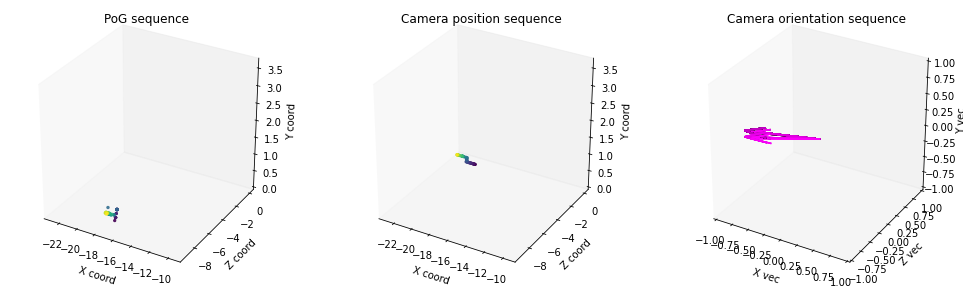

In [ ]:
plot_seq(actual)

Future prediction:

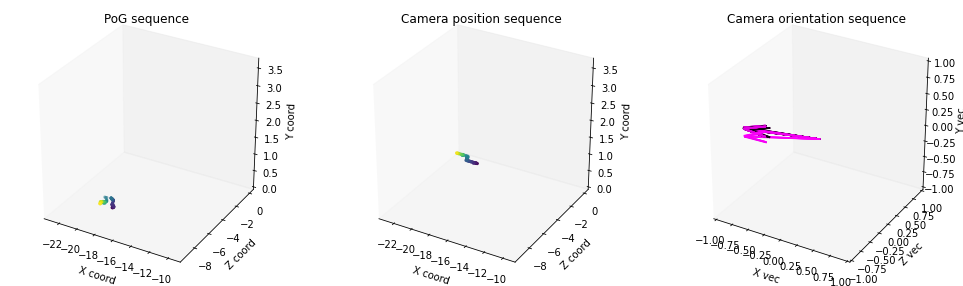

In [ ]:
plot_seq(predicted)

**Line plots for each of the 9 features:**

Let's plot the ground truth sequence against the predicted sequence for each of the 9 features, if the graphs line up then our model can successfully predict short term changes.

PoG X:

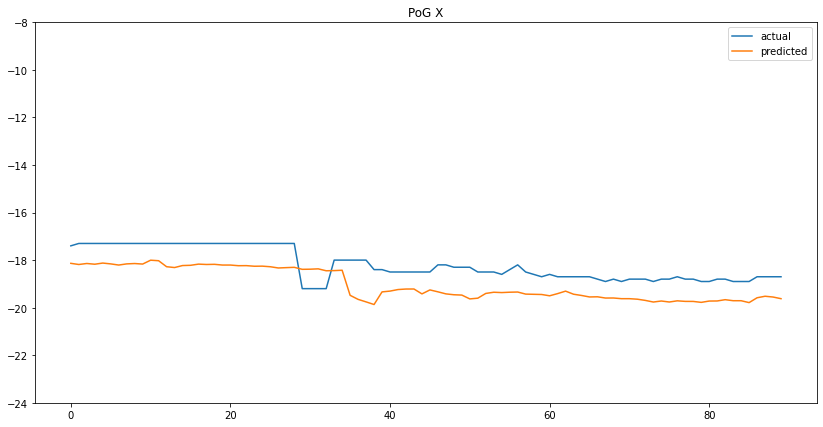

In [ ]:
df = pd.DataFrame({"actual" : actual[:,0].tolist(), "predicted" : predicted[:,0].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="PoG X")

PoG Y:

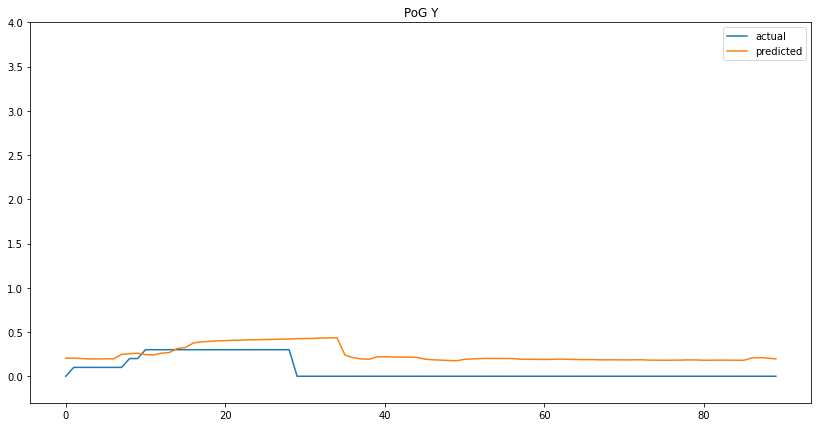

In [ ]:
df = pd.DataFrame({"actual" : actual[:,1].tolist(), "predicted" : predicted[:,1].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="PoG Y")

PoG Z:

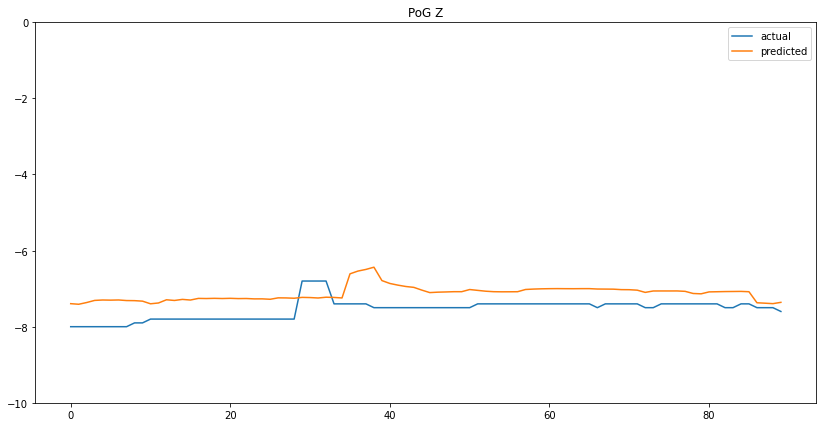

In [ ]:
df = pd.DataFrame({"actual" : actual[:,2].tolist(), "predicted" : predicted[:,2].tolist()})
df.plot(figsize=(14,7), ylim=(-10,0), title="PoG Z")

Camera position X:

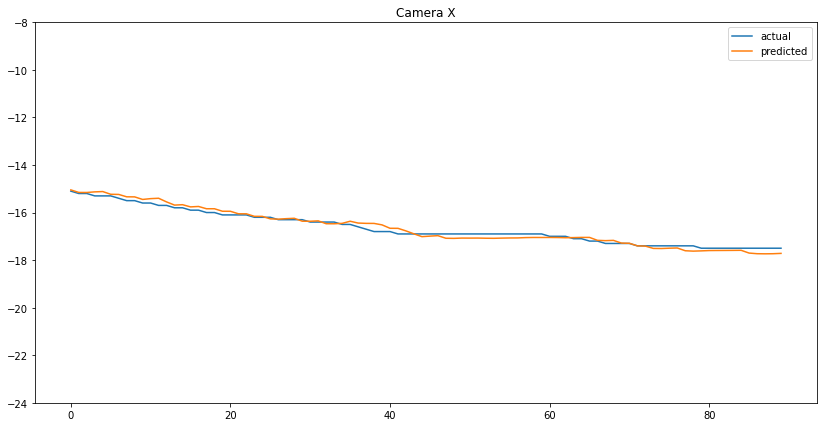

In [ ]:
df = pd.DataFrame({"actual" : actual[:,3].tolist(), "predicted" : predicted[:,3].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="Camera X")

Camera position Y:

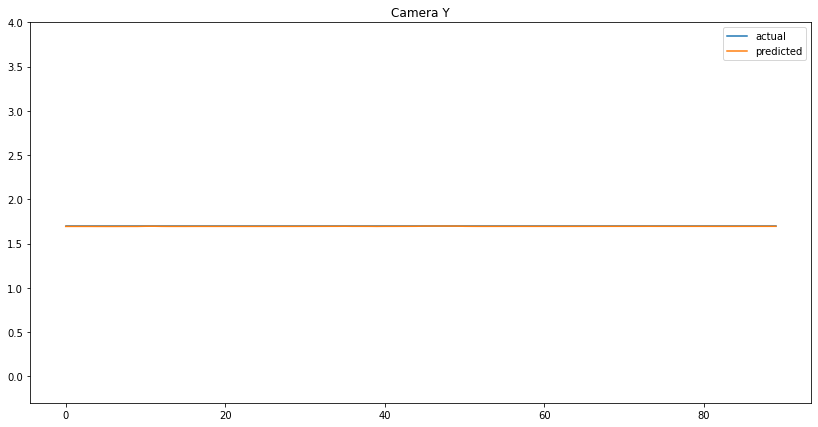

In [ ]:
df = pd.DataFrame({"actual" : actual[:,4].tolist(), "predicted" : predicted[:,4].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="Camera Y")

Camera Position Z:

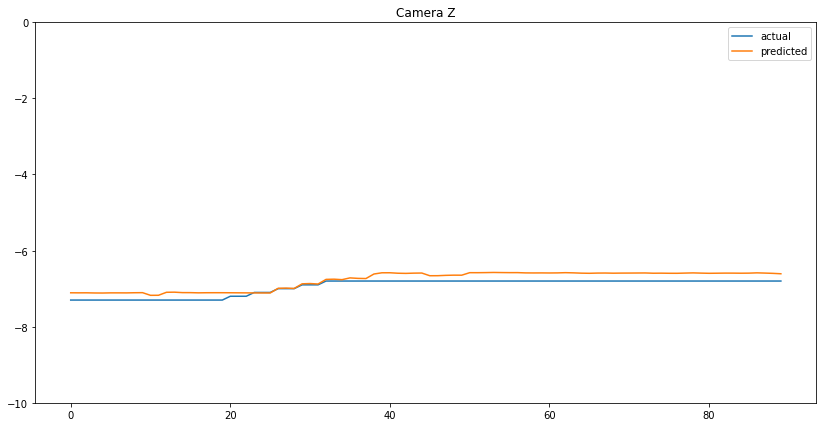

In [ ]:
df = pd.DataFrame({"actual" : actual[:,5].tolist(), "predicted" : predicted[:,5].tolist()})
df.plot(figsize=(14,7), ylim=(-10,0), title="Camera Z")

Camera Vector X:

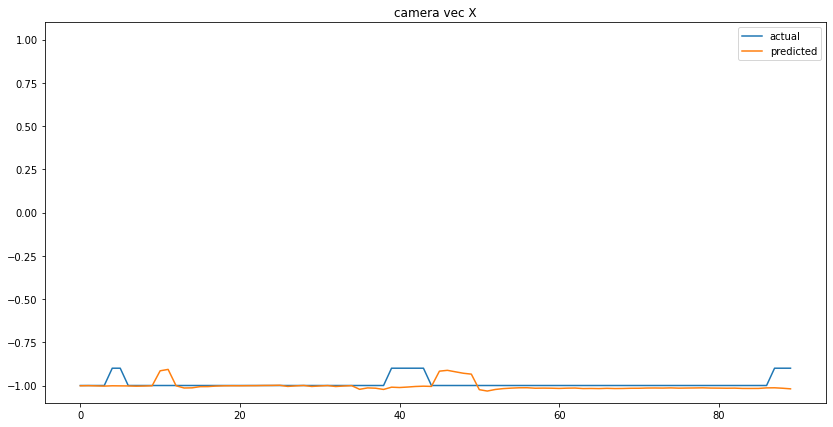

In [ ]:
df = pd.DataFrame({"actual" : actual[:,6].tolist(), "predicted" : predicted[:,6].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="camera vec X")

Camera Vector Y:

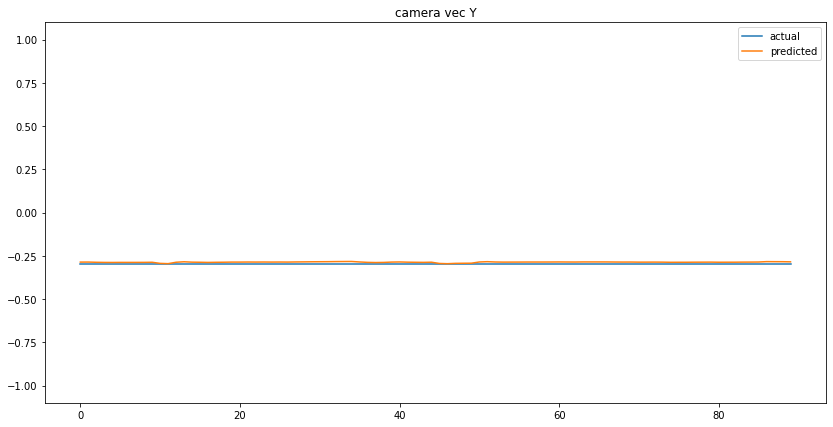

In [ ]:
df = pd.DataFrame({"actual" : actual[:,7].tolist(), "predicted" : predicted[:,7].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="camera vec Y")

Camera Vector Z:

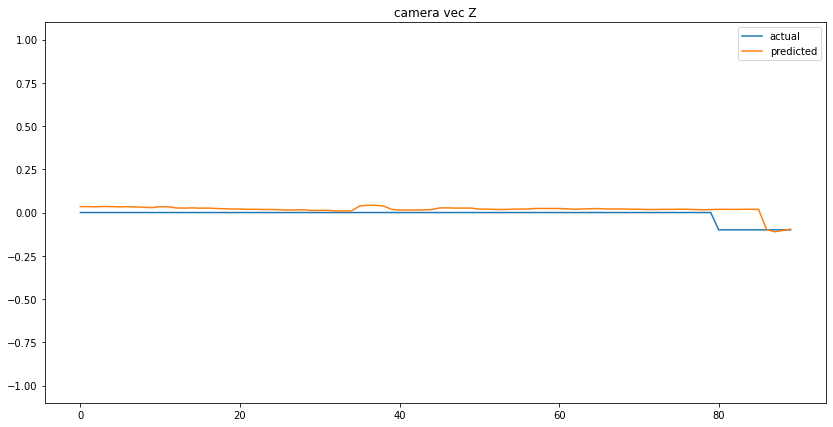

In [ ]:
df = pd.DataFrame({"actual" : actual[:,8].tolist(), "predicted" : predicted[:,8].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="camera vec Z")

**Some obseravtions:**

By looking at the line graphs we can see that the models predictions fit well to the actual sequences. This is unfortunately not the whole story - because we gave the model the ability to predict 5 time steps into the future ideally we want the model to be able to predict changes before they happen (the graphs would line up in this case). 

If you look closely at the graphs you can see the model almost "lags" behind when trying to predict short term variations and changes. For all we know the model could just be taking the current input and outputting similar values, so maybe it has learnt to just reproduce its inputs.

Next we will look at the model's ability to predict long term trends and changes.

# Sequence Generation

Using the model let's generate a sequence of 100 frames (3.33 seconds) into the future and see if it has learned longer term dependencies / patterns. 

The following code takes a sequence of 90 frames from the test data passes it through the LSTM and generates 100 more frames into the future (using its output as input).

In [ ]:
future = 100

# genetrate a random test sequence from the test data
idx = np.random.choice(test_ids)
start = np.random.randint(0, dataset[idx].shape[0] - seq_len - future - 1)

inputs = np.array(dataset[idx][start:start+seq_len, :], dtype=np.float32)
targets = np.array(dataset[idx][start+1:start+seq_len+future+1, :])

# transform input
inputs = (inputs - means) / stds
inputs = torch.tensor(inputs).to(device)

outputs = model(inputs, future=future)

gen_seq = outputs.squeeze(0).data.cpu().numpy()

# cut the first bit of the sequence
actual_seq = targets[seq_len:, :]

# inverse transform the generated sequence
gen_seq = gen_seq * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)

# cut the first bit of the sequence
gen_seq = gen_seq[seq_len:, :]

**Plot the 3D point clouds and vectors**

Ground truth:

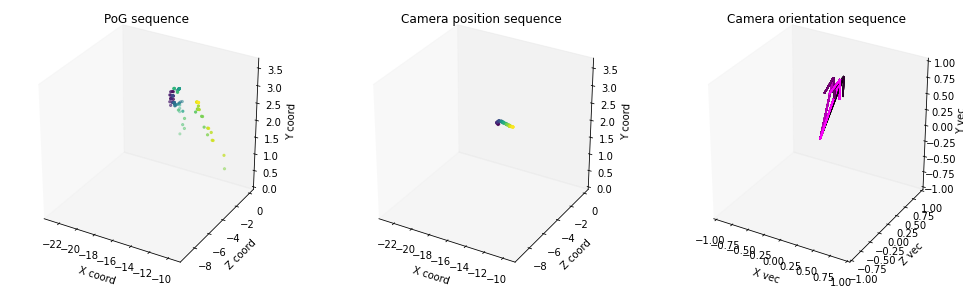

In [ ]:
plot_seq(actual_seq)

Generated sequence:

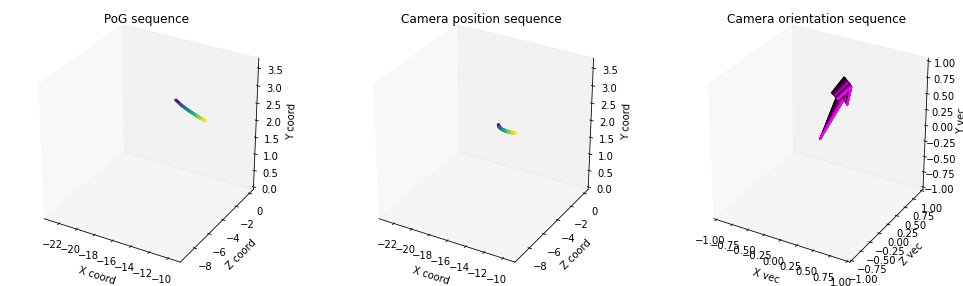

In [ ]:
plot_seq(gen_seq)

**Line plots for each of the 9 features:**

Let's plot the ground truth sequence against the generated sequence for each of the 9 features and see if we got close.

PoG X:

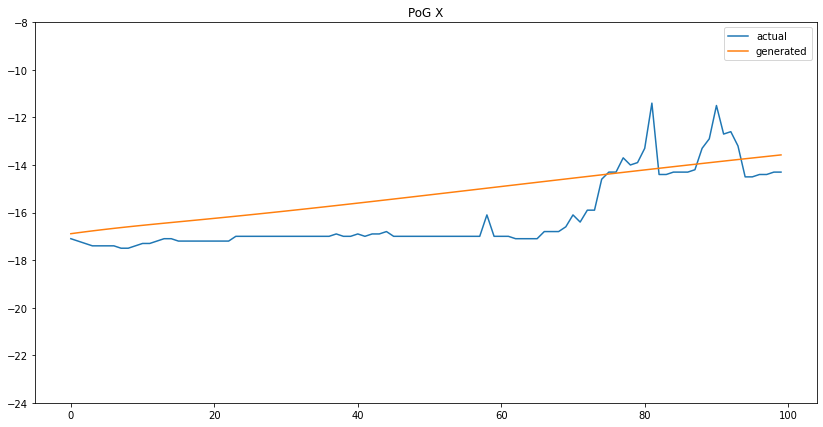

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,0].tolist(), "generated" : gen_seq[:,0].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="PoG X")

PoG Y:

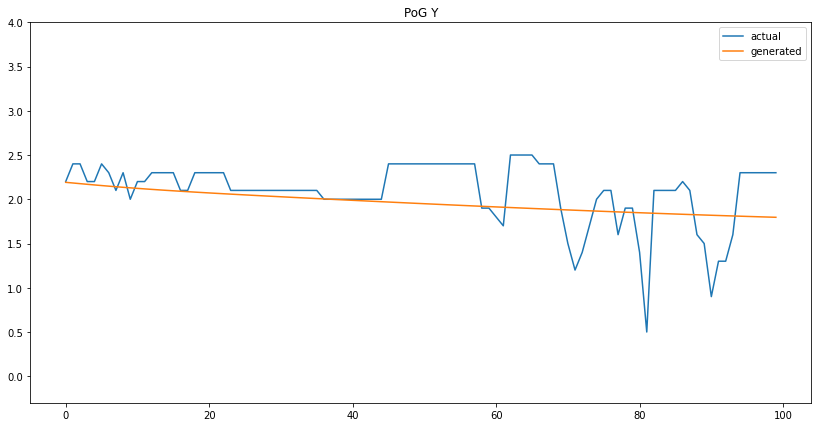

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,1].tolist(), "generated" : gen_seq[:,1].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="PoG Y")

PoG Z:

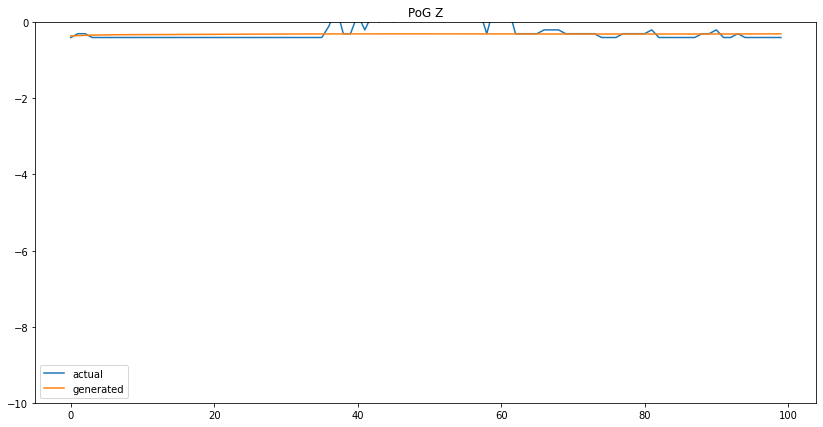

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,2].tolist(), "generated" : gen_seq[:,2].tolist()})
df.plot(figsize=(14,7), ylim=(-10,1), title="PoG Z")

Camera Position X:

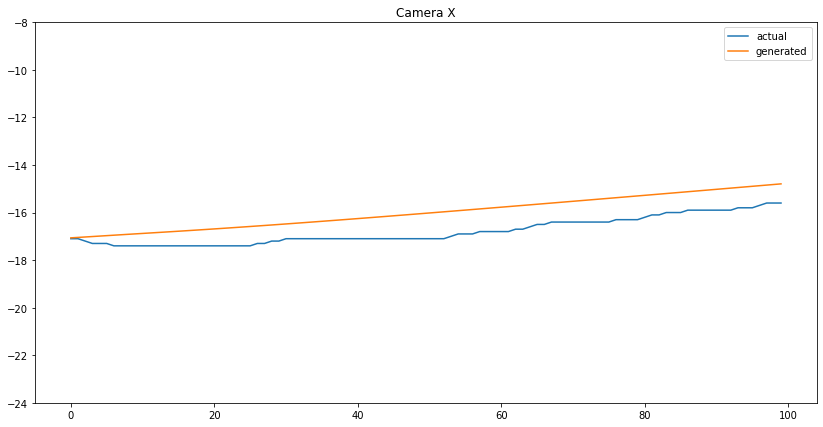

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,3].tolist(), "generated" : gen_seq[:,3].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="Camera X")

Camera Position Y:

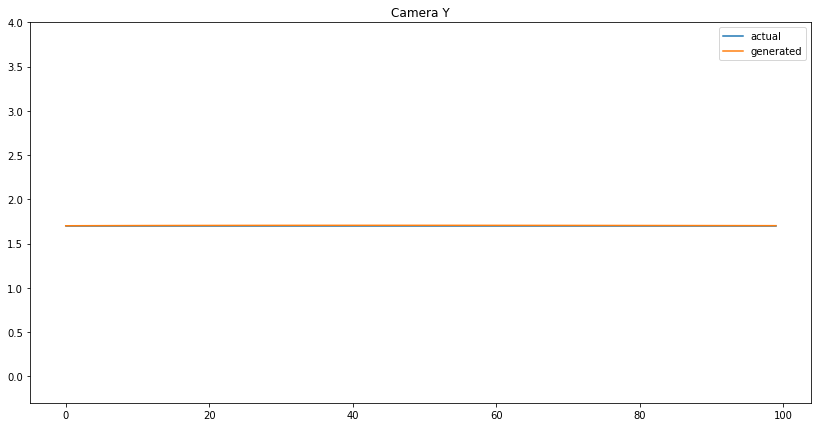

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,4].tolist(), "generated" : gen_seq[:,4].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="Camera Y")

Camera Position Z:

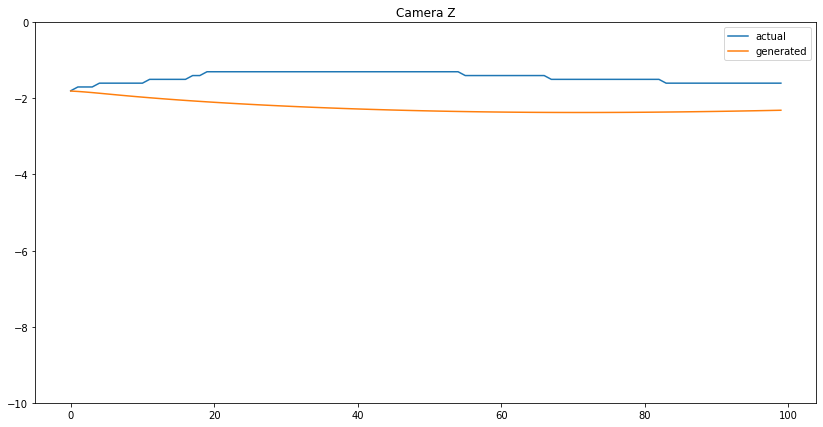

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,5].tolist(), "generated" : gen_seq[:,5].tolist()})
df.plot(figsize=(14,7), ylim=(-10,1), title="Camera Z")

Camera Vector X:

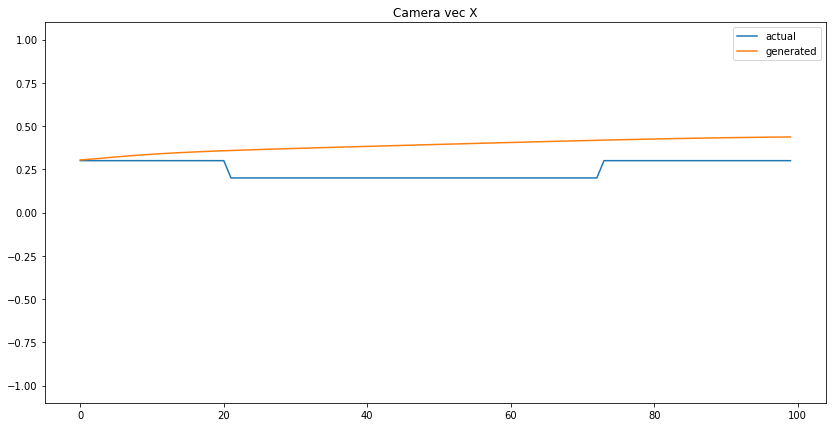

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,6].tolist(), "generated" : gen_seq[:,6].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec X")

Camera Vector Y:

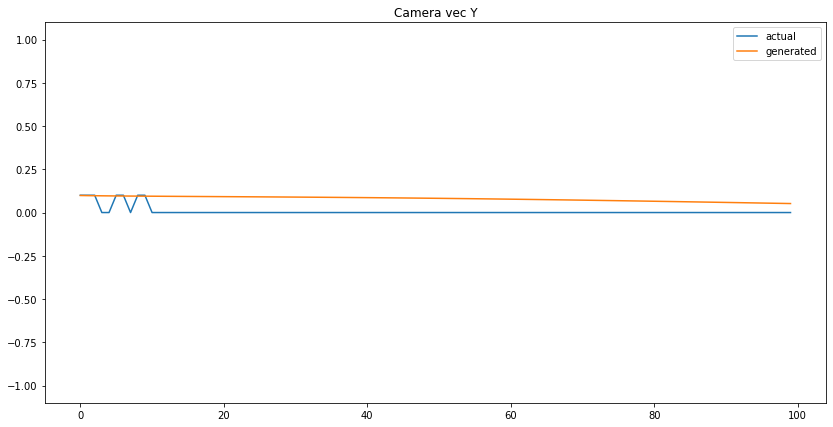

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,7].tolist(), "generated" : gen_seq[:,7].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec Y")

Camera Vector Z:

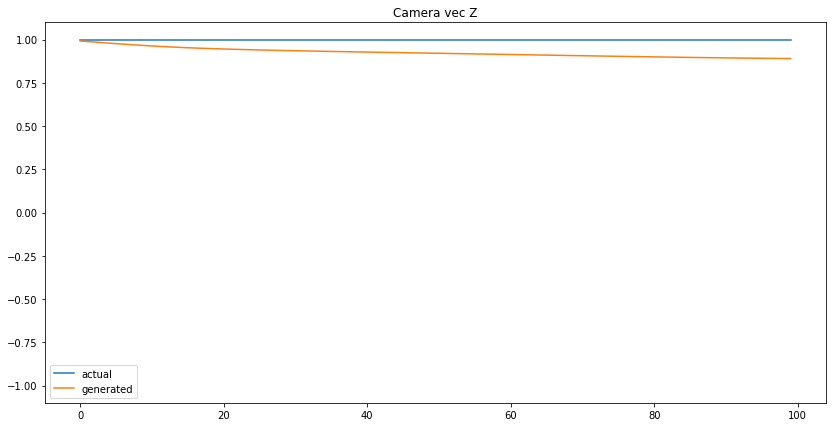

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,8].tolist(), "generated" : gen_seq[:,8].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec Z")

**Some obseravtions:**

It is clear that the model seems to be able to predict long term trends into the future only using 3 seconds (90 frames) of prior input. For the most part the model's predicted trajectory into the future follows the same trend at the actual subsequent trajectory for each of the features.

This is encouraging because it suggests the model has learnt more than just reproducing its inputs but it still fails at generating short term deviations.

# Some Remarks  

There are various things we can continue to explore with this setup of the problem:
*   Train on longer sequences (perhaps 300 frames).
*   Try different methods for training the model.
*   More thorough parameter turning.
*   Observe the effect of sub sampling the frames.

The current method for evaluating the model is also not very thorough - we looked at a few graphs for a few different sequences from the test data. We will probably need a more thorough validation and accuracy score for the model - deriving this will be a priority. 






